# Scenario 1
18 month hackathon (02/26/2024)

### Load dependencies and interfaces

In [17]:
import os
import pyciemss
import torch
import pandas as pd
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
import matplotlib.pyplot as plt
smoke_test = ('CI' in os.environ)

### Select models and data

In [2]:
# MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
MODEL_PATH = "/Users/vigneshsella/Documents/GitHub/program-milestones/18-month-milestone/hackathon/epi/scenario1/ciemss/"
DATA_PATH = r"https://raw.githubusercontent.com/ciemss/program-milestones/epi-scenario-1/18-month-milestone/hackathon/epi/Scenario%201%20Supplemental/"

model1 = os.path.join(MODEL_PATH, "SEIRD_base_model01_petrinet.json")
dataset1 = os.path.join(DATA_PATH, "UK_compartments.csv")

In [3]:
# Load datasets 
df = pd.read_csv(dataset1, index_col=0)

# Group by 't' and 'compartment', then sum 'y' values
grouped = df.groupby(['t', 'compartment'])['y'].sum()

# Reshape the DataFrame and fill missing values with 0
df_new = grouped.unstack(fill_value=0)

# Make a column 'I' which sums 'ICase' and 'IMild' and delete the original columns
df_new['I'] = df_new['ICase'] + df_new['IMild']
df_new.drop(columns=['ICase', 'IMild'], inplace=True)

# Output to CSV
df_new.to_csv('UK_SEIRD.csv')

# Redefine the dataset
dataset1 = 'UK_SEIRD.csv'

### Set parameters for sampling

In [4]:
start_time = 0.0
end_time = 200.
logging_step_size = 10.0
num_samples = 10

## Sample interface
Take `num_samples` number of samples from the (prior) distribution invoked by the chosen model.

### Sample from model 1

In [5]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time, solver_method='euler')
result1["unprocessed_result"]

{'persistent_beta': tensor([0.5211, 0.7348, 0.4427, 0.5317, 0.7863, 0.4205, 0.3489, 0.3771, 0.1101,
         0.4127]),
 'persistent_death': tensor([0.0047, 0.0098, 0.0040, 0.0076, 0.0061, 0.0015, 0.0051, 0.0026, 0.0029,
         0.0081]),
 'persistent_gamma': tensor([0.1707, 0.4448, 0.2507, 0.4787, 0.2540, 0.3185, 0.4974, 0.2580, 0.3390,
         0.4866]),
 'persistent_I0': tensor([4.6767, 3.4619, 3.1090, 2.3899, 8.6731, 2.8666, 7.5240, 3.6135, 8.8451,
         1.4020]),
 'D_state': tensor([[ 3.7906e-02,  8.2165e-01, -4.5408e-01,  1.1740e+01, -3.0432e+01,
           2.0854e+02, -8.2335e+02,  4.3141e+03, -1.9344e+04,  9.4857e+04,
          -4.2752e+05,  2.3499e+06, -2.5745e+06, -1.5216e+07, -9.0459e+08,
          -1.1173e+11, -9.5786e+14, -1.0055e+21,        -inf],
         [ 1.5027e-01,  3.9730e+00, -1.2957e+01,  1.2126e+02, -7.6623e+02,
           5.3962e+03, -3.6802e+04,  2.5353e+05, -1.7294e+06,  1.2395e+07,
          -5.8196e+07,  6.8225e+08,  7.6778e+10, -1.4772e+14,  2.7958e+19,


## Calibrate interface
Calibrate a model to a dataset by mapping model state varibale or observables to columns in the dataset

In [6]:
### Choose data to calibrate on
# Load CSV 'UK_SEIRD.csv'
df = pd.read_csv(dataset1, index_col=0)

# Output until t = 40 to CSV, t is the index column
df_calibrate = df[df.index <= 40]

# Rename the index column to 'Timestamp'
df_calibrate.index.name = 'Timestamp'

# Output to CSV
df_calibrate.to_csv('UK_SEIRD_calibrate.csv')

In [10]:
data_mapping = {"I": "I", "D": "D"} # data_mapping = "column_name": "observable/state_variable"
calibration_data = 'UK_SEIRD_calibrate.csv'
num_iterations = 100 
calibrated_results = pyciemss.calibrate(model1, calibration_data, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
calibrated_results

{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 1253201.7610704005}

## Sample interface with intervention

In [11]:
# start_time = 0.0
# end_time = 200.
reduction_factor = .45 # 45% reduction in beta
new_beta = parameter_estimates()['persistent_beta'] * (1-reduction_factor)
intervention_time = torch.tensor(40.)
logging_step_size = 1.0
num_samples = 10
result = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={intervention_time: {"beta": new_beta}}, solver_method="euler",
                         inferred_parameters=parameter_estimates, )
result["data"]

,timepoint_id,sample_id,persistent_beta_param,persistent_death_param,persistent_gamma_param,persistent_I0_param,D_state,E_state,I_state,R_state,S_state,infected_observable_state,dead_observable_state
0,0,0,0.612724,0.005428,0.219745,10.962867,0.013077,36.717216,18.553833,2.395957e+00,67885984.0,18.553833,0.013077
1,1,0,0.612724,0.005428,0.219745,10.962867,0.035210,38.906296,23.656027,6.450935e+00,67885976.0,23.656027,0.035210
2,2,0,0.612724,0.005428,0.219745,10.962867,0.063429,43.674339,28.184309,1.162101e+01,67885960.0,28.184309,0.063429
3,3,0,0.612724,0.005428,0.219745,10.962867,0.097049,50.024960,32.909534,1.778075e+01,67885944.0,32.909534,0.097049
4,4,0,0.612724,0.005428,0.219745,10.962867,0.136307,57.683178,38.184071,2.497319e+01,67885920.0,38.184071,0.136307
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,194,9,0.565255,0.004515,0.225892,10.778086,3835.740234,196511.421875,180238.781250,8.457962e+05,66659664.0,180238.781250,3835.740234
1986,195,9,0.565255,0.004515,0.225892,10.778086,4019.549561,205598.203125,188652.140625,8.863269e+05,66601448.0,188652.140625,4019.549561
1987,196,9,0.565255,0.004515,0.225892,10.778086,4211.938965,215077.484375,197436.687500,9.287496e+05,66540568.0,197436.687500,4211.938965
1988,197,9,0.565255,0.004515,0.225892,10.778086,4413.286621,224963.515625,206606.687500,9.731476e+05,66476912.0,206606.687500,4413.286621


## Plot results

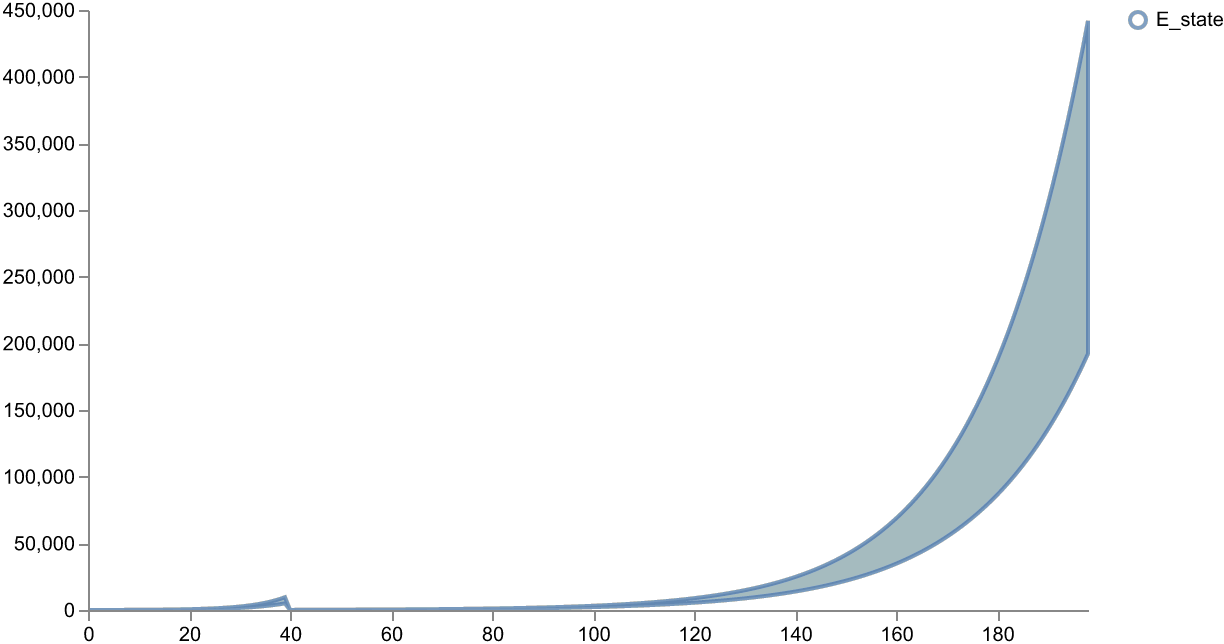